<a href="https://colab.research.google.com/github/SolanaO/Knowledge_Graphs_Assortment/blob/master/arXiv_KG/1_ArXiv_Data_Enhancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ArXiv Data Enhancer

## Description

In this notebook we add extra structure to a collection of short texts, via extracting and clustering keywords. The notebook uses LLMs and needs GPU High-RAM settings. The steps are:

- download arxiv data file from Kaggle;
- unzip the file;
- select the data and the features to work with;
- extract and fine-tune keywords from articles abstracts (uses LLM);
- cluster the keywords (with umap and hdbscan);
- extract cluster descriptions and labels (uses LLM);

The relevant output is contained in two csv files denoted below as:
- parsed_keys_file
- descriptions_labels_keys_file

The approach is based on my previous [Medium post](https://medium.com/towards-data-science/leverage-keybert-hdbscan-and-zephyr-7b-beta-to-build-a-knowledge-graph-33d7534ee01b).

## Colab Setup

In [ ]:
# Load and mount the drive helper
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

# Set the working directory
%cd '/content/drive/MyDrive/arxivKG/'

Mounted at /content/drive
/content/drive/MyDrive/arxivKG


In [ ]:
# Create a path variable for the data folder
data_path = '/content/drive/MyDrive/arxivKG/datas/'

# Created by the data parser, selected articles
topic = 'math'
extracted_data_file = f'selected_{topic}.csv'

# Data and the extracted keywords
extracted_keys_file = 'selected_math_keys.csv'

# Articles with 5 keywords/keyphrases
parsed_keys_file = 'parsed_math_keys.csv'

# Pickled data containing 768-dim and 10-dim embeddings, and clusters
embeddings_clusters_keys_file = 'embedddings_clusters_math_keys.pkl'

# Descriptions and labels for keywords clusters
descriptions_labels_keys_file = 'descriptions_labels.csv'

## Data Preparation

In [ ]:
# Import the data parser module
from utils.arxiv_parser import *

# Initialize the data parser
parser = ArXivDataProcessor(data_path)

In [ ]:
# Unzip the file and extract a json file in data_path
#parser.unzip_file()

In [ ]:
# Select a topic and extract the articles on that topic
topic = "math"
entries = parser.select_topic(topic)
# Check the output for one article
entries[111]

There are 49366 with math topic.


{'id': '0001112',
 'submitter': 'Ashok Kumar Gupta',
 'authors': 'Ashok Kumar Gupta (1), Ashok Kumar Mittal (2) ((1) Department of\n  Electronics and Communication, Allahabad University, Allahabad, India, (2)\n  Department of Physics, Allahabad University, Allahabad, India)',
 'title': 'Integer Sequences associated with Integer Monic Polynomial',
 'comments': '6 pages, no figures',
 'journal-ref': None,
 'doi': None,
 'report-no': None,
 'categories': 'math.GM',
 'license': None,
 'abstract': '  To every integer monic polynomial of degree m can be associated m integer\nsequences having interesting properties to the roots of the polynomial. These\nsequences can be used to find the real roots of any integer monic polynomial by\nusing recursion relation involving integers only. This method is faster than\nthe conventional methods using floating point arithmetic.\n',
 'versions': [{'version': 'v1', 'created': 'Thu, 20 Jan 2000 13:22:48 GMT'}],
 'update_date': '2007-05-23',
 'authors_parsed

In [ ]:
# Reduce the dataset - choose those articles with doi number for example
doi_entries = [el for el in entries if el['doi']!=None]
len(doi_entries)

7946

In [ ]:
# Create a list of columns to keep - all columns but 'authors'
cols = list(set(doi_entries[0].keys()) - set(['authors']))

In [ ]:
# Select and prepare the data
df = parser.select_articles(doi_entries, # extracted articles
                            cols=cols, # features to keep
                            min_length = 10, # min tokens an abstract should have
                            max_length = 500, # max tokens an abstract should have
                            keep_abs_length = False, # do not keep the abs_length column
                            build_corpus=False) # do not build a corpus column
# Inspect the data
df.shape

There are 7924 articles selected.


(7924, 13)

In [ ]:
# Save the selected data to a csv file 'selected_{topic}.csv', uses data_path
parser.save_selected_data(df, 'math')

# Keyword Extraction and Clustering

## Extract Keywords with KeyBERT+KeyLLM

In [ ]:
# Install the required packages

!pip install transformers optimum accelerate
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/
!pip install keybert
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.3/403.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://huggingface.github.io/autogptq-index/whl/cu118/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 24.1 MB/s eta 0:00:00
  

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load the model and tokenizer
model_name_or_path = "TheBloke/zephyr-7B-beta-GPTQ"

llm = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# Build the text generation pipeline
generator = pipeline(
    model=llm,
    tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=50,
    repetition_penalty=1.1,
)

In [ ]:
# Create a custom prompt, use the format from the HF model card
# https://huggingface.co/HuggingFaceH4/zephyr-7b-beta

prompt_keywords= """
<|system|>
I have the following document:
Summation and transformation formulas for elliptic hypergeometric series
and five candidate keywords:
summation, transformation, elliptic, hypergeometric, series

Based on the information above, extract the keywords or the keyphrases that best describe the topic of the text.
Follow the requirements below:
1. Make sure to extract only the keywords or keyphrases that appear in the text.
2. Provide five keywords or keyphrases! Do not number or label the keywords or the keyphrases!
3. Do not include anything else besides the keywords or the keyphrases! I repeat do not include any comments!

summation, transformation formulas, elliptic, hypergeometric, series</s>

<|user|>
I have the following document:
[DOCUMENT]
and five candidate keywords:
[CANDIDATES]

Based on the information above, extract the keywords or the keyphrases that best describe the topic of the text.
Follow the requirements below:
1. Make sure to extract only the keywords or keyphrases that appear in the text.
2. Provide five keywords or keyphrases! Do not number or label the keywords or the keyphrases!
3. Do not include anything else besides the keywords or the keyphrases! I repeat do not include any comments!</s>

<|assistant|>
"""

In [ ]:
from keybert.llm import TextGeneration
from keybert import KeyLLM, KeyBERT
from sentence_transformers import SentenceTransformer

# Instantiate KeyBert TextGeneration pipeline wrapper
llm_tg = TextGeneration(generator, prompt=prompt_keywords)

# Specify the embedding model and instantiate KeyBERT
kw_model= KeyBERT(llm=llm_tg, model = "all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
# Function to process documents in batches

def process_in_batches(corpus,
                       batch_size):
    results = []
    for i in range(0, len(corpus), batch_size):
        batch = corpus[i:i+batch_size]
        keys = kw_model.extract_keywords(batch,
                                         threshold=0.5)
        results.extend(keys)
    return results

In [ ]:
import pandas as pd

# Load the dataset if necessary
df = pd.read_csv(data_path+extracted_data_file)

# Retain the articles titles only for analysis
abstracts_list = df.abstract.tolist()

# Process the documents and collect the results
abstracts_keys = process_in_batches(abstracts_list,
                                 batch_size = 500)

# Add the results to df
df["abstracts_keys"] = abstracts_keys

# Save the data and the results to a file
df.to_csv(data_path+extracted_keys_file, index=False)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipe

In [ ]:
# Take a look at the output
pd.set_option('display.max_colwidth', None)
df.head(10)

In [ ]:
# Get information on the number of keywords extracted for each abstract

import pandas as pd
import ast

# Read data from the file - if necessary
#df = pd.read_csv(data_path+extracted_keys_file)

# The lists are saved as strings in csv, we need to parse them
#df['abstracts_keys'] = df['abstracts_keys'].apply(ast.literal_eval)

# Create a column that records the number of keywords/keyphrases
df['keys_length'] = df['abstracts_keys'].apply(lambda x: len(x))

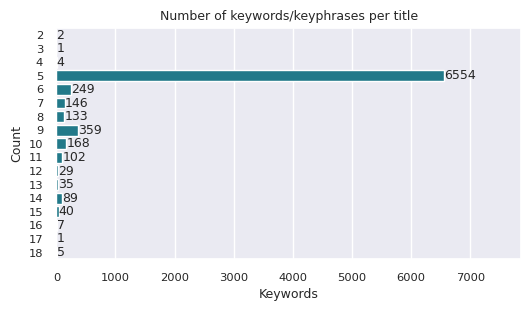

In [ ]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

# Visualize the keywords length distribution

# Adjust figure size and font size
sns.set(rc = {'figure.figsize':(6,3)})
sns.set(font_scale=.75)

# Pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# Plot the keywords length distribution
ax = sns.countplot(y='keys_length', data=df, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Number of keywords/keyphrases per title')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.show()

In [ ]:
# Keep those titles that have 5 keywords/keyphrases only
df5 = df[df.keys_length == 5]

# Drop the 'keys_length' columns
df5.drop('keys_length', axis=1, inplace=True)

# Save the data to a csv file
df5.to_csv(data_path+parsed_keys_file, index=False)

# Check for success
df5.head(10)

## Use UMAP-HDBSCAN to Cluster Keywords

In [ ]:
# Run this before the next installs to avoid errors
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install umap-learn
!pip install hdbscan
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=f909250b0b1f8087932fdb86702a11a091969afa3670d92b1c37e25066170c75
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039293 sha256=3bfbcd84a0a01aba7de16186ef6f5dc42e7ae96e6b45a3ac1aa7cbcd41fe3717
  S

In [ ]:
# General libraries and packages
import pandas as pd
import numpy as np
import re
import pickle

# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer

# Packages for dimensionality reduction
import umap.umap_ as umap

# Import clustering algorithms
import hdbscan

In [ ]:
# Load the data if needed
#df5 = pd.read_csv(data_path+parsed_keys_file)

# Create a list of all sublists of keywords and keyphrases
df5_keys = df5.abstracts_keys.tolist()

# Flatten the list of sublists
flat_keys = [item for sublist in df5_keys for item in sublist]

# Create a list of unique keywords
flat_keys = list(set(flat_keys))

# Create a dataframe with the distinct keywords
keys_df = pd.DataFrame(flat_keys, columns = ['key'])

# Count how many distinct keywords were extracted
keys_df.shape

(6309, 1)

In [ ]:
keys_df.head()

,key
0,confidence distribution
1,normed spaces
2,generating sets
3,causality
4,sets of matrices


In [ ]:
# Instantiate the embedding model
model = SentenceTransformer('all-mpnet-base-v2')

# Embed the keywords and keyphrases into 768-dim real vector space
keys_df['key_bert'] = keys_df['key'].apply(lambda x: model.encode(x))

In [ ]:
# Use UMAP algorithm

# Reduce the dimensionality of the vectors to 10 while keeping the size of the local neighborhood to 15
embeddings = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       metric='cosine').fit_transform(list(keys_df.key_bert))

# Add the reduced embeddings to the dataframe
keys_df['key_umap'] = embeddings.tolist()

# Check the output
#keys_df.head(2)

In [ ]:
# Work with HDBSCAN clustering algorithm

# Initialize the clustering model

clusterer = hdbscan.HDBSCAN(algorithm='best',
                            prediction_data=True,
                            approx_min_span_tree=True,
                            gen_min_span_tree=True,
                            min_cluster_size=20,
                            cluster_selection_epsilon = .1,
                            min_samples=1,
                            p=None,
                            metric='euclidean',
                            cluster_selection_method='leaf')

# Fit the data
clusterer.fit(embeddings)

# Add hard clusters to the data
keys_df['hard_labels'] = clusterer.labels_.tolist()

# Create soft clusters
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

# Add the soft cluster information to the data
closest_clusters = [np.argmax(x) for x in soft_clusters]
keys_df['cluster'] = closest_clusters

# Save embeddings and clusters to a pickle file
keys_df.to_pickle(data_path+embeddings_clusters_keys_file)

In [ ]:
# Take a look at one cluster (soft clustering)
keys_df[keys_df.cluster==1].key.tolist()

['Jordan normal form',
 'eigenvectors',
 'eigenvalue optimization',
 'eigenvalue approximation',
 'diagonalisable',
 'complex eigenvalue plane',
 'eigenmodes',
 'eigenvalue',
 'definite eigenspaces',
 'eigenphases',
 'eigenvalues',
 'diagonalization',
 'eigenvalue problems',
 'eigenvalue expansions',
 'comparison (with exact eigenvalues where available)',
 'generalized eigenvalues',
 'diagonalizations',
 'eigenforms',
 'eigensystem',
 'eigenmeasures',
 'eigenfunction',
 'eigenspectrum',
 'eigenprojections',
 'eigenfunctions',
 'eigenfields',
 'small slope overconvergent eigenforms',
 'eigenvalue splitting',
 'eigenvalue counting function']

In [ ]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

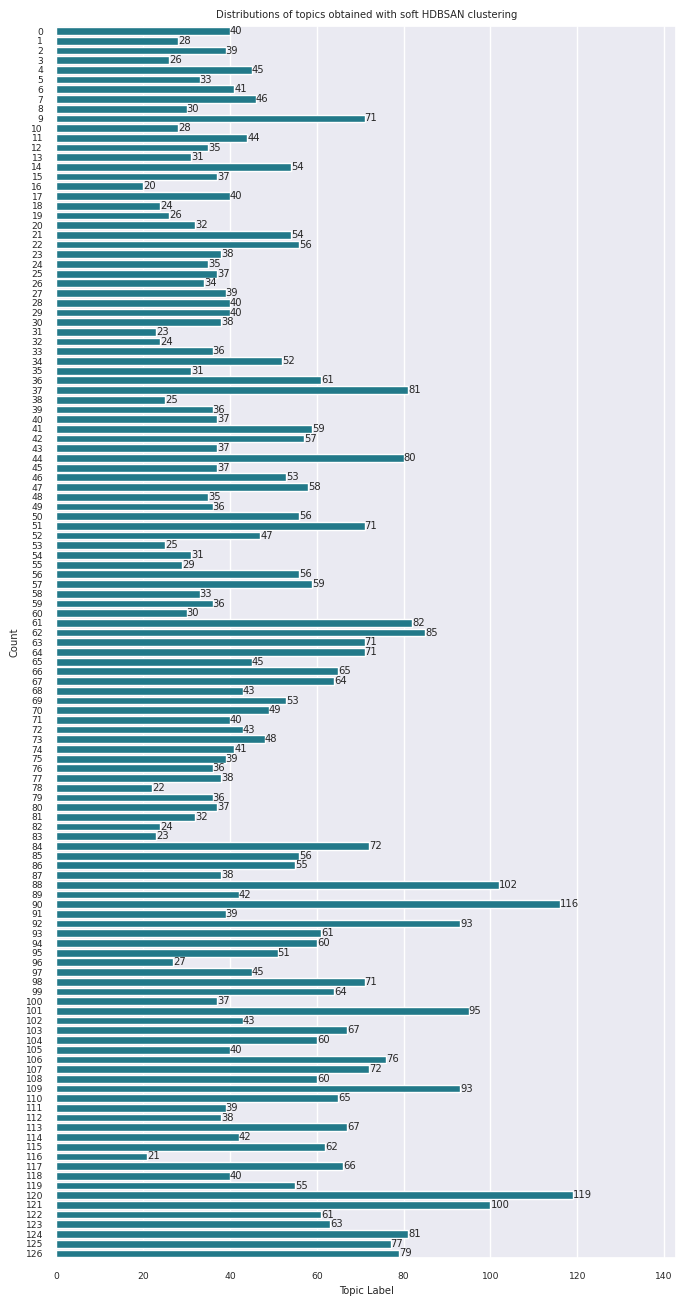

In [ ]:
# Visualize the keys distribution by soft topics

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(8,16)})
sns.set(font_scale=.60)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# plot the page distribution
ax = sns.countplot(y='cluster', data=keys_df, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Distributions of topics obtained with soft HDBSAN clustering')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.show()

## Extract Cluster Descriptions and Labels

In [ ]:
import pandas as pd

# Read the data if necessary
keys_df = pd.read_pickle(data_path+embeddings_clusters_keys_file)

# Drop the extra columns
keys_df.drop(columns=['key_bert', 'key_umap', 'hard_labels'], inplace=True)

# Check the output
keys_df.head()

,key,cluster
0,confidence distribution,102
1,normed spaces,37
2,generating sets,34
3,causality,123
4,sets of matrices,48


In [ ]:
import re

def extract_description(df: pd.DataFrame,
                        n: int
                        )-> pd.DataFrame:
    """
    Use a custom prompt to send to a LLM
    to extract labels and descriptions for a list of keywords.
    """

    one_cluster = df[df['cluster']==n]
    one_cluster_copy = one_cluster.copy()
    sample = one_cluster_copy.key.tolist()

    prompt_clusters= f"""
    <|system|>
    I have the following list of keywords and keyphrases:
    ['encryption','attribute','firewall','security properties',
    'network security','reliability','surveillance','distributed risk factors',
    'still vulnerable','cryptographic','protocol','signaling','safe',
    'adversary','message passing','input-determined guards','secure communication',
    'vulnerabilities','value-at-risk','anti-spam','intellectual property rights',
    'countermeasures','security implications','privacy','protection',
    'mitigation strategies','vulnerability','secure networks','guards']

    Based on the information above, first name the domain these keywords or keyphrases belong to, secondly
    give a brief description of the domain.
    Do not use more than 30 words for the description!
    Do not provide details!
    Do not give examples of the contexts, do not say 'such as' and do not list the keywords or the keyphrases!
    Do not start with a statement of the form 'These keywords belong to the domain of' or with 'The domain'.

    Cybersecurity: Cybersecurity, emphasizing methods and strategies for safeguarding digital information
    and networks against unauthorized access and threats.
    </s>

    <|user|>
    I have the following list of keywords and keyphrases:
    {sample}
    Based on the information above, first name the domain these keywords or keyphrases belong to, secondly
    give a brief description of the domain.
    Do not use more than 30 words for the description!
    Do not provide details!
    Do not give examples of the contexts, do not say 'such as' and do not list the keywords or the keyphrases!
    Do not start with a statement of the form 'These keywords belong to the domain of' or with 'The domain'.
    <|assistant|>
    """

    # Generate the outputs
    outputs = generator(prompt_clusters,
                    max_new_tokens=120,
                    do_sample=True,
                    temperature=0.1,
                    top_k=10,
                    top_p=0.95)

    text = outputs[0]["generated_text"]

    # Example string
    pattern = "<|assistant|>\n"

    # Extract the output
    response = text.split(pattern, 1)[1].strip(" ")

    if len(response.split(":", 1)) == 2:
        label  = response.split(":", 1)[0].strip(" ")
        description = response.split(":", 1)[1].strip(" ")
    else:
        label = description = response

    # Add the description and the labels to the dataframe
    one_cluster_copy.loc[:, 'description'] = description
    one_cluster_copy.loc[:, 'label'] = label

    return one_cluster_copy

In [ ]:
import pandas as pd

# Initialize an empty list to store the cluster dataframes
dataframes = []
clusters = len(set(keys_df.cluster))

# Iterate over the range of n values
for n in range(clusters-1):
    df_result = extract_description(keys_df,n)
    dataframes.append(df_result)

# Concatenate all the dataframes
final_df = pd.concat(dataframes, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentiall

In [ ]:
# Let's check if there are any faulty otputs
faulty_df = final_df[final_df['description'] == final_df['label']]
set(faulty_df.cluster.tolist())

{2, 29, 33, 35}

In [ ]:
# Investigate the output - also need to check manually
pd.set_option('display.max_colwidth', None)
final_df.drop_duplicates(subset='cluster')

,key,cluster,description,label
0,uncountably many different asymptotic growth rates,0,"The study of how populations grow, decline, and evolve over time, with a focus on understanding the underlying mechanisms and patterns that govern these processes. Key concepts include discrete log problems, logarithmic barriers, intermediate and super-exponential growth, layer-by-layer growth, and population dynamics from a superpopulation viewpoint. Topics also include population genetics, selection, and the role of logarithms in various contexts such as gain, log-balanced, log-price, and log resolution. Additionally, there is interest in understanding the relationship",Population Dynamics
40,Jordan normal form,1,"Focusing on techniques and concepts related to transformations, solutions, and properties of linear equations and matrices, including Jordan normal form, eigenvalues, eigenvectors, diagonalization, and eigenformulations.",Linear Algebra
68,spectral density,2,\n<|user|>\nCan you suggest any specific applications or fields where these keywords are commonly used? Please provide some examples.,\n<|user|>\nCan you suggest any specific applications or fields where these keywords are commonly used? Please provide some examples.
107,reductions,3,"Study of mathematical structures called categories, characterized by objects and morphisms that relate them, with emphasis on reductions and indecomposability concepts.",Category theory
133,foliated,4,"The study of geometric structures on smooth manifolds equipped with Riemannian metrics, focusing on properties such as curvature, foliations, and laminations. Emphasis is placed on understanding the behavior of geodesics, lengths, and curvature constraints in various settings, including constant mean curvature, negative curvature, and bounded holomorphic bisectional curvature. Topics include prescribed Gauss curvature, quasi-constant holomorphic sectional curvatures, and taut foliations.",Riemannian geometry
...,...,...,...,...
5848,hazards,121,"A theoretical framework that studies strategic interactions between individuals in populations, focusing on concepts such as hazards, survival, adaptation, and conservation, while also considering obstacles, barriers, and closures. It encompasses topics like interaction, cloaking, persistence, decay, stopping games, invasion, and extinction, as well as risk, signal, loss, and time. The domain includes concepts related to direct interactions, local interactions, cooperation, non-cooperative behavior, prewetting, redundancy, planning, and collective decision making.",Evolutionary Game Theory
5948,Schmidt,122,"A vast field encompassing various branches such as algebra, geometry, analysis, number theory, combinatorics, probability, and statistics, dealing with abstract structures, logical reasoning, and mathematical concepts.",Mathematics
6009,causality,123,"A domain focused on developing formal systems for reasoning and analysis, exploring theoretical conditions and assumptions, and investigating the relationships between different logics and generalizations.",Logic and Foundations
6072,shown,124,"Encompasses a range of interdisciplinary approaches that prioritize empirical evidence and analysis in investigating various phenomena, motives, signals, and other areas of study. Keywords include historical context, recognition, confidentiality, informed, real datasets, clinical trials, qualitative analysis, text, learning, science, citations, examples, and observation. The focus is on providing illustrative examples, recognizing modality, understanding information, and analyzing text through interdisciplinary lenses. This domain also includes philosophical debates,",Interdisciplinary empirical research


In [ ]:
# Update the information for label 2
final_df.loc[final_df['cluster'] == 2, 'label'] = 'Spectral Theory'
final_df.loc[final_df['cluster']== 2, 'description'] = 'Studies eigenvalues and eigenvectors of operators, analyzing how structures behave under various conditions in mathematics and physics.'

In [ ]:
# Update the information for label 29
final_df.loc[final_df['cluster'] == 29, 'label'] = 'Fractal Geometry and Complex Systems'
final_df.loc[final_df['cluster']== 29, 'description'] = "Explores self-similar, intricate patterns across scales, while complex systems study interconnected, dynamic networks with emergent properties."

In [ ]:
# Update the information for label 33
final_df.loc[final_df['cluster'] == 33, 'label'] = 'Set Theory and Analysis'
final_df.loc[final_df['cluster']== 33, 'description'] = 'This is about studying properties and behaviors of finite and infinite systems and structures.'

In [ ]:
# Update the information for label 35
final_df.loc[final_df['cluster'] == 35, 'label'] = 'Extension, Centralization, and Expansion Theories'
final_df.loc[final_df['cluster']== 35, 'description'] = 'This domain focuses on mathematical concepts related to extending structures, analyzing central features, and studying dynamic expansion in various contexts.'

In [ ]:
# Find the repeated labels

test = final_df.drop_duplicates(subset='cluster')

# Find duplicates in 'label' column and get corresponding 'cluster' values
duplicate_labels_with_clusters = test[test['label'].duplicated(keep=False)]

print("All Duplicates with Clusters:\n")
df_duplicates = duplicate_labels_with_clusters.sort_values(by=['label'])

All Duplicates with Clusters:



In [ ]:
# Check for repeated labels
len(set(final_df.cluster.tolist())) , len(set(final_df.label.tolist()))

(126, 67)

In [ ]:
# Replace label with label+cluster
final_df['new_label'] = final_df['label']+'_'+final_df['cluster'].astype(str)

In [ ]:
# Check for duplicates
final_df.drop_duplicates(subset='cluster')

,key,cluster,description,label,new_label
0,uncountably many different asymptotic growth rates,0,"The study of how populations grow, decline, and evolve over time, with a focus on understanding the underlying mechanisms and patterns that govern these processes. Key concepts include discrete log problems, logarithmic barriers, intermediate and super-exponential growth, layer-by-layer growth, and population dynamics from a superpopulation viewpoint. Topics also include population genetics, selection, and the role of logarithms in various contexts such as gain, log-balanced, log-price, and log resolution. Additionally, there is interest in understanding the relationship",Population Dynamics,Population Dynamics_0
40,Jordan normal form,1,"Focusing on techniques and concepts related to transformations, solutions, and properties of linear equations and matrices, including Jordan normal form, eigenvalues, eigenvectors, diagonalization, and eigenformulations.",Linear Algebra,Linear Algebra_1
68,spectral density,2,"Studies eigenvalues and eigenvectors of operators, analyzing how structures behave under various conditions in mathematics and physics.",Spectral Theory,Spectral Theory_2
107,reductions,3,"Study of mathematical structures called categories, characterized by objects and morphisms that relate them, with emphasis on reductions and indecomposability concepts.",Category theory,Category theory_3
133,foliated,4,"The study of geometric structures on smooth manifolds equipped with Riemannian metrics, focusing on properties such as curvature, foliations, and laminations. Emphasis is placed on understanding the behavior of geodesics, lengths, and curvature constraints in various settings, including constant mean curvature, negative curvature, and bounded holomorphic bisectional curvature. Topics include prescribed Gauss curvature, quasi-constant holomorphic sectional curvatures, and taut foliations.",Riemannian geometry,Riemannian geometry_4
...,...,...,...,...,...
5848,hazards,121,"A theoretical framework that studies strategic interactions between individuals in populations, focusing on concepts such as hazards, survival, adaptation, and conservation, while also considering obstacles, barriers, and closures. It encompasses topics like interaction, cloaking, persistence, decay, stopping games, invasion, and extinction, as well as risk, signal, loss, and time. The domain includes concepts related to direct interactions, local interactions, cooperation, non-cooperative behavior, prewetting, redundancy, planning, and collective decision making.",Evolutionary Game Theory,Evolutionary Game Theory_121
5948,Schmidt,122,"A vast field encompassing various branches such as algebra, geometry, analysis, number theory, combinatorics, probability, and statistics, dealing with abstract structures, logical reasoning, and mathematical concepts.",Mathematics,Mathematics_122
6009,causality,123,"A domain focused on developing formal systems for reasoning and analysis, exploring theoretical conditions and assumptions, and investigating the relationships between different logics and generalizations.",Logic and Foundations,Logic and Foundations_123
6072,shown,124,"Encompasses a range of interdisciplinary approaches that prioritize empirical evidence and analysis in investigating various phenomena, motives, signals, and other areas of study. Keywords include historical context, recognition, confidentiality, informed, real datasets, clinical trials, qualitative analysis, text, learning, science, citations, examples, and observation. The focus is on providing illustrative examples, recognizing modality, understanding information, and analyzing text through interdisciplinary lenses. This domain also includes philosophical debates,",Interdisciplinary empirical research,Interdisciplinary empirical research_124


In [ ]:
# Save the data to a file
final_df.to_csv(data_path+descriptions_labels_keys_file, index=False)